## Introduction
Because of the unique scoring of American Football, where scoring most commonly occurs in intervals of 7 or 3 points (and more rarely, 2, 6, or 8), the final scores of NFL games tend to take on certain discrete values; some are incredibly common and occur thousands of times while others have yet to occur. NFL fans on the internet have tracked the occurance of NFL final scores and fans have given the name "scoirgami" to the event of a novel scoring combination occuring for the first time.

The below project attempts various machine learning techniques for predicting if an in-progress NFL game will end in a scorigami.

## Outline
1. Importing Libraries and dataset
2. Establishing baselines for prediction
3. Random Forest algorithm
4. Deep Neural Network
5. Pretraining DNN
5. Recurrant Neural Network

## 1. Importing Libraries and Dataset

In [51]:

# Load libraries
import numpy as np
from sklearn.model_selection import train_test_split

import math
from sklearn.metrics import precision_recall_curve,auc,average_precision_score
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

from tensorflow.keras import layers, regularizers
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
tf.random.set_seed(42)

X is in the shape (6757, 60, 16). This corresponds to 6,757 NFL games occuring between the 2001 and 2025 season. In each game, 60 observations are made corresponding to each minute of gameplay in a regulation football game (not including overtime) of 16 features of interest corresponding to the cumulative number of different scoring plays that have occured in that game. The feature labels are contained in the file X_features.csv

y is an array of booleans representing whether each of the games would have been a scorigami had it occured in the 2001 season.

In [52]:
# Load dataset
# See getData.py for details on how dataset was obtained and cleaned

X = np.load('X.npy')
y = np.load('y.npy')
print(X.shape)
print(y.shape)

with open('X_features.csv', 'r') as f:
  print(f.read())

#Split into train/test/cross-validation

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

(6757, 60, 16)
(6757, 1)
homeTds, awayTds, homePATs, awayPATs, home2Cvs, away2Cvs, homeFGs, awayFGs, homeSafeties, awaySafeties, totalSafeties, homeDef2ptConv, awayDef2ptConv, currentHome, currentAway, totalPoints, 


Features are recorded as "home" and "away" teams. However, for purposes of Scorigami, it does not matter if the teams are home or away; therefore, the X_train dataset is duplicated, reversing "home" and "away" teams.

In [53]:
X_train_r = np.ndarray(X_train.shape, float)

X_train_r[:, :, 0] = X_train[:, :, 1]
X_train_r[:, :, 1] = X_train[:, :, 0]
X_train_r[:, :, 2] = X_train[:, :, 3]
X_train_r[:, :, 3] = X_train[:, :, 2]
X_train_r[:, :, 4] = X_train[:, :, 5]
X_train_r[:, :, 5] = X_train[:, :, 4]
X_train_r[:, :, 6] = X_train[:, :, 7]
X_train_r[:, :, 7] = X_train[:, :, 6]
X_train_r[:, :, 8] = X_train[:, :, 9]
X_train_r[:, :, 9] = X_train[:, :, 8]
X_train_r[:, :, 10] = X_train[:, :, 10]
X_train_r[:, :, 11] = X_train[:, :, 12]
X_train_r[:, :, 12] = X_train[:, :, 11]
X_train_r[:, :, 13] = X_train[:, :, 14]
X_train_r[:, :, 14] = X_train[:, :, 13]
X_train_r[:, :, 15] = X_train[:, :, 15]

X_train = np.append(X_train, X_train_r, axis=0)
print(X_train.shape)
y_train = np.append(y_train, y_train, axis=0)
print(y_train.shape)


(10810, 60, 16)
(10810, 1)


To demonstrate predicting an in-progress NFL game, a "time snapshot" will be made at the 50th minute of the game (10 minutes left in game time). The X array will be a 2D array containing only observations of the interest features at the 50th minute of the game

In [54]:
time = 50
X_train_snapshot = X_train[:,time-1,:]
X_test_snapshot = X_test[:,time-1,:]

print(X_train_snapshot.shape)
print(X_test_snapshot.shape)

(10810, 16)
(1352, 16)


# 2. Baseline Models

To evaluate the performance of my machine learning models, I will create two different deterministic predictors as baseline comparisons. The first one predicts that a game will end in a scorigami if the current score would be a scorigami if the game ended immediately; the second predicts that the game will end in a scorigami if the current score is 2 SD above the mean (high scoring games are more likely to be scorigami).

In [55]:
# import isScorigami function used in Current Scorigami Predictor
!wget https://github.com/liam-moyer/Scorigami-Modeling/raw/refs/heads/main/EveryScorigami.xlsx
!pip install fastexcel
from isScorigami import isScorigami

#Current Scorigami predictor: if a scorigami at time t, then predict scorigami
def currentscorigamiredictor(testSet):
  out = []
  for i in range(testSet.shape[0]):
    if isScorigami(testSet[i,13],testSet[i,14],2001):
      out.append(1)
    else:
      out.append(0)
  return out


meanTotalScore = np.average(X_train_snapshot[:,15])
stdTotalScore = np.std(X_train_snapshot[:,15])

  #Predict positive if home + away is more than 2 SD from mean
def scorepredictor(testSet):
  out = []
  for i in range(testSet.shape[0]):
    if testSet[i,15] > (meanTotalScore + 2*stdTotalScore):
      out.append(1)
    else:
      out.append(0)
  return out


--2026-02-07 21:54:31--  https://github.com/liam-moyer/Scorigami-Modeling/raw/refs/heads/main/EveryScorigami.xlsx
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/liam-moyer/Scorigami-Modeling/refs/heads/main/EveryScorigami.xlsx [following]
--2026-02-07 21:54:32--  https://raw.githubusercontent.com/liam-moyer/Scorigami-Modeling/refs/heads/main/EveryScorigami.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1326019 (1.3M) [application/octet-stream]
Saving to: ‘EveryScorigami.xlsx.1’

EveryScorigami.xlsx 100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2026-02-07 21:54:32 (22.4 MB/s

The metrics of the two baselines are shown below. Two different baselines were selected because they will perform differently at different time snapshots. Closer to the end of the football game, the "current scorigami" predictor will outperform the "high scoring" predictor.

In either case, neither predictor is particularly accurate considering the high variability of an NFL game.

AUCPR (trapezoidal) = 0.2712


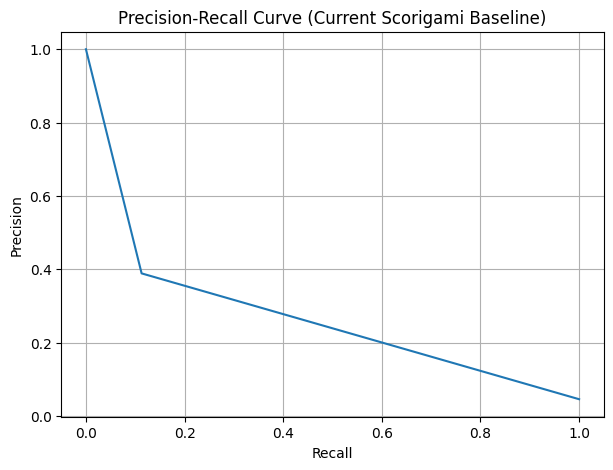

F1 score: 0.175


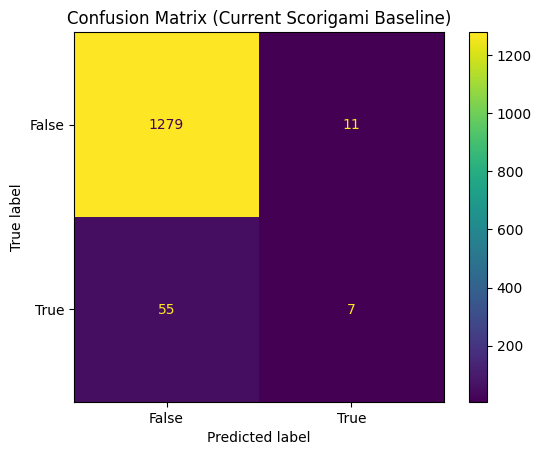

In [56]:
current_baseline_prediction = currentscorigamiredictor(X_test_snapshot)

precision_curbl,recall_curbl,thresholds_curbl = precision_recall_curve(y_test,current_baseline_prediction)
aucpr_curbl = auc(recall_curbl, precision_curbl)

print(f"AUCPR (trapezoidal) = {aucpr_curbl:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_curbl, precision_curbl)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Current Scorigami Baseline)")
plt.grid(True)
plt.show()

f1bl_current = f1_score(y_test,current_baseline_prediction)

print(f"F1 score: {f1bl_current}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,current_baseline_prediction)
plt.title("Confusion Matrix (Current Scorigami Baseline)")
plt.show()

AUCPR (trapezoidal) = 0.2819


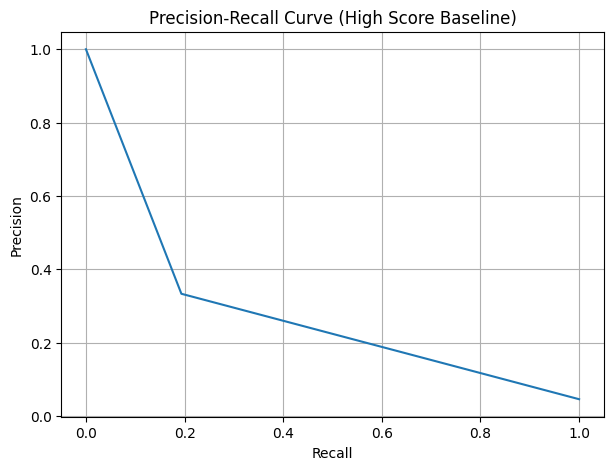

F1 score: 0.24489795918367346


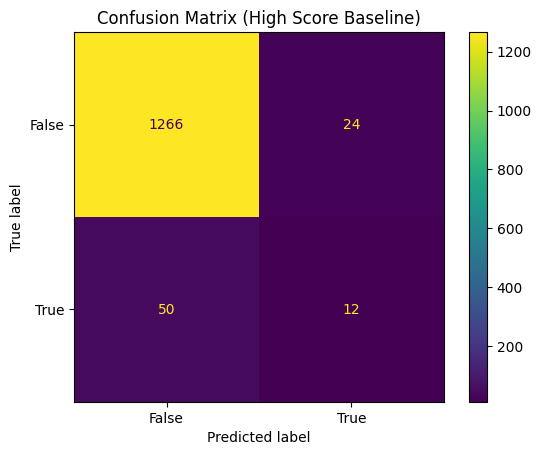

In [57]:
score_baseline_prediction = scorepredictor(X_test_snapshot)

precision_scorebl,recall_scorebl,thresholds_scorebl = precision_recall_curve(y_test,score_baseline_prediction)
aucpr_scorebl = auc(recall_scorebl, precision_scorebl)

print(f"AUCPR (trapezoidal) = {aucpr_scorebl:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_scorebl, precision_scorebl)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (High Score Baseline)")
plt.grid(True)
plt.show()

f1bl_score = f1_score(y_test,score_baseline_prediction)

print(f"F1 score: {f1bl_score}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,score_baseline_prediction)
plt.title("Confusion Matrix (High Score Baseline)")
plt.show()

## 2. Random Forest Model

Because of the high degree of class imbalance in this dataset, I will be using the Balanced Random Forest classifier through imbalanced-learn, which is in turn based on the random forest classifier in Scikit-Learn

In [58]:
#balanced random forest
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(
    n_estimators=50000, sampling_strategy="all", replacement=True,
    bootstrap=False, warm_start=True, verbose=True, n_jobs=-1
)
brf.fit(X_train_snapshot, np.ravel(y_train))
predicted_brf = brf.predict(X_test_snapshot)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 11226 tasks 

### Results and Analysis

The random forest algorithm was able to sucessfully outperform the baseline predictors in F1 score. However, this was not a dramatic improvement over the baseline. Nonetheless, one benefit of the random forest algorithm is in its comparitive computational simplicity compared to the later ANN models.

AUCPR (trapezoidal) = 0.4158


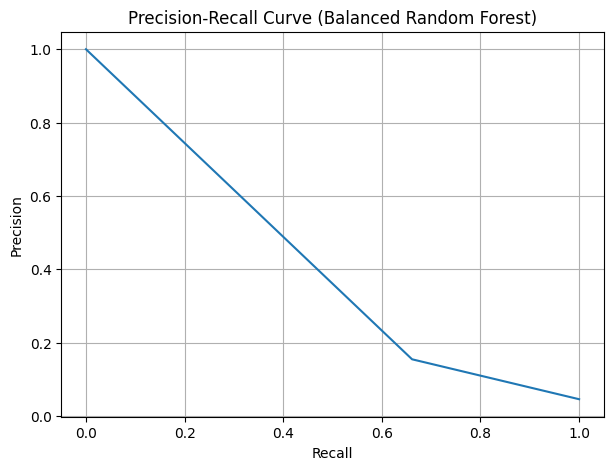

F1 score: 0.25076452599388377


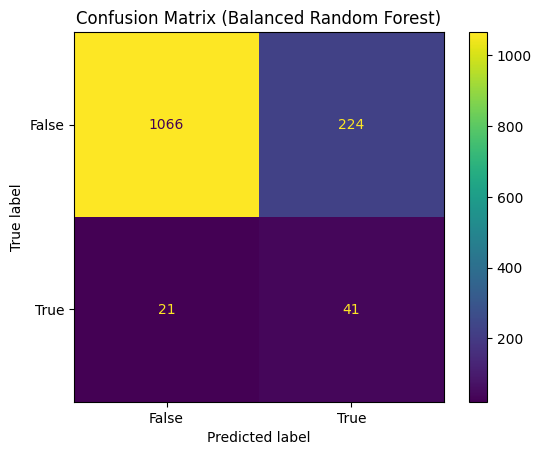

In [59]:
precision_brf,recall_brf,thresholds_brf = precision_recall_curve(y_test,predicted_brf)
aucpr_brf = auc(recall_brf, precision_brf)

print(f"AUCPR (trapezoidal) = {aucpr_brf:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_brf, precision_brf)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Balanced Random Forest)")
plt.grid(True)
plt.show()

f1brf = f1_score(y_test,predicted_brf)

print(f"F1 score: {f1brf}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,predicted_brf)
plt.title("Confusion Matrix (Balanced Random Forest)")
plt.show()

## 3. Artificial Neural Network

The hyperparameters used for this ANN were determined using hyperparameter tuning via a Bayseian search implemented in the Karas-tuner API. Full details on this can be found in the hyperameterTuning.py file.

In [62]:
# Import saved hyperparamters from csv; five best hyperparameters were saved
hyperparameters = []

import csv

with open('hyperparameters.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='|')
    for row in reader:
      hyperparameters.append(eval(str(row[0])))


for i in range(len(hyperparameters)):
  print(hyperparameters[i])


from tensorflow.keras import layers, regularizers
!pip install keras-tuner
import keras_tuner
from sklearn.metrics import f1_score


myhps = keras_tuner.HyperParameters()

myhps.values = hyperparameters[0]

{'n_hidden': 6, 'n_neurons': 705, 'l2_regularization': 7.987012956647178e-09, 'dropout': 0.16341448176778672, 'alpha': 0.8079125952780066, 'gamma': 1.8426841518731756, 'learning_rate': 0.00019959280115989004, 'normalize': False}


In [63]:
# Build hypermodel

tf.keras.backend.set_floatx(
    'float64'
)

class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    n_hidden = hp.Int("n_hidden", min_value=5, max_value=20, default=10)
    n_neurons = hp.Int("n_neurons", min_value=100, max_value=1024)
    model = tf.keras.Sequential()
    for _ in range(n_hidden):
      model.add(tf.keras.layers.Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2=hp.Float("l2_regularization",min_value=1e-14,max_value=1e-2,sampling="log"))))
    #model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout",min_value=0,max_value=0.25)))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=hp.Float("alpha",min_value=0.8,max_value=0.999,default=0.9), gamma=hp.Float("gamma",min_value=1,max_value=4))
    model.compile(loss=loss,optimizer = tf.keras.optimizers.AdamW(learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
                                                                  #beta_1 = hp.Float("beta_1",min_value=0.8,max_value=1,default=0.9),
                                                                  #beta_2=hp.Float("beta_2",min_value=0.99,max_value=1,default=0.999)
                                                                  ), metrics=[tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score(average="macro", threshold=0.5)])
    return model
  def fit(self, hp, model, X, y, *args, **kwargs):
    if True:
    #if hp.Boolean("normalize"):
      norm_layer = tf.keras.layers.Normalization()
      X = norm_layer(X)
    return model.fit( X, y,
          *args,
          #batch_size=hp.Int("batch_size", min_value=50, max_value=250, step=10),
          **kwargs
        )
hp = keras_tuner.HyperParameters()
hypermodel = MyHyperModel()
build_model = hypermodel.build(hp)



model = hypermodel.build(myhps)

In [64]:
#Fit HP & Predict classes
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="f1_score",mode='max',patience=30, restore_best_weights=True) # callbacks=[early_stopping_cb]
hypermodel.fit(hp,model,X_train_snapshot, np.array(y_train).reshape(-1, 1), epochs=100)

predicted_ANN = model.predict(X_test_snapshot).flatten().round()

Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - auc_18: 0.0507 - f1_score: 0.0848 - loss: 0.6543
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0503 - f1_score: 0.0828 - loss: 0.0739
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0620 - f1_score: 0.0854 - loss: 0.0455
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0754 - f1_score: 0.1411 - loss: 0.0363
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0739 - f1_score: 0.1277 - loss: 0.0339
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0878 - f1_score: 0.1435 - loss: 0.0313
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0899 - f1_score: 0.1433 - loss: 0.0296
Epoch 8/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.0951 - f1_score: 0.1370 - loss: 0.0292
Epoch 9/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18: 0.1181 - f1_score: 0.1664 - loss: 0.0270
Epoch 10/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_18:

As can be seen from below graphs,the ANN model outperforms the baselines and offers modest improvement over the previous random forest model. Nonetheless, accurately predicting the occurence of a scorigami remains difficult as can be seen by the overall low F1 scores.

AUCPR (trapezoidal) = 0.3534


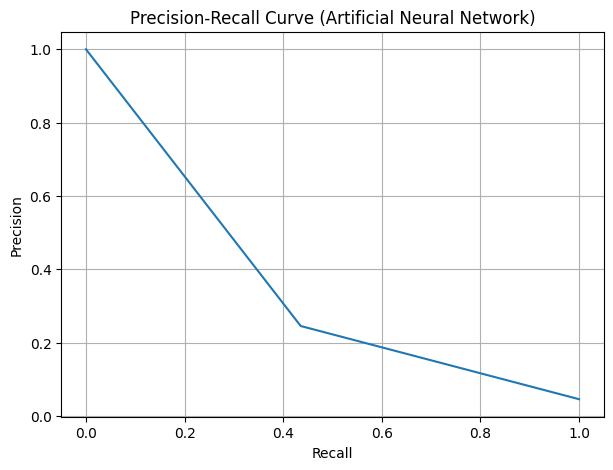

F1 score: 0.313953488372093


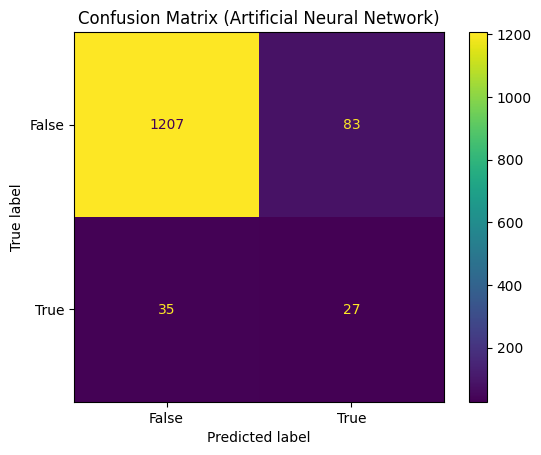

In [65]:
precision_ANN,recall_ANN,thresholds_ANN = precision_recall_curve(y_test,predicted_ANN)
aucpr_ANN = auc(recall_ANN, precision_ANN)

print(f"AUCPR (trapezoidal) = {aucpr_ANN:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_ANN, precision_ANN)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Artificial Neural Network)")
plt.grid(True)
plt.show()

f1_ANN = f1_score(y_test,predicted_ANN)

print(f"F1 score: {f1_ANN}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,predicted_ANN)
plt.title("Confusion Matrix (Artificial Neural Network)")
plt.show()

## 4. Pre-training the model on a synthetic dataset

Because the dataset used contains only the previous 25 years of NFL games, any scorigami that occurred before the 2001 season will not be in the training dataset. Further, because scorigami are based on the occurence of exceptionally rare scoring combinations, an exceptionally large training set will be required to capture all possible scoring combinations. To help alleviate this, the below code will model NFL scoring as following a poisson distribution and simulating 100,000 NFL games. The ANN model is then pretrained on these simulated games and transfer learning is used so that the pre-trained layers are then trained on our historic training data.

In [ ]:
# Creates synthetic dataset to simulate NFL scoring according to Poisson distribution

X_syn=np.ndarray((0,16),int)

for i in range(100000):
  homeTDs = np.random.poisson(lam=2.4)
  awayTDs = np.random.poisson(lam=2.4)
  homePATs = 0
  awayPATs = 0
  home2Cvs = 0
  away2Cvs = 0
  homeDef2ptConv = 0
  awayDef2ptConv = 0
  for j in range(homeTDs):
    k = np.random.uniform()
    if k <= 0.001:
      awayDef2ptConv += 1
    if k <= 0.05:
      home2Cvs +=1
    if k<= 0.95:
      homePATs += 1
  for j in range(awayTDs):
    k = np.random.uniform()
    if k <= 0.001:
      homeDef2ptConv += 1
    if k <= 0.05:
      away2Cvs += 1
    if k <= 0.95:
      awayPATs += 1
  homeFG = np.random.poisson(lam=1.6)
  awayFG = np.random.poisson(lam=1.6)
  homeSafeties = np.random.poisson(lam=0.05)
  awaySafeties = np.random.poisson(lam=0.05)
  totalSafeties = homeSafeties + awaySafeties
  currentHome = homeTDs*6 + homePATs + home2Cvs*2 + homeDef2ptConv * 2 +  homeFG*3 + homeSafeties*2
  currentAway = awayTDs*6 + awayPATs + away2Cvs*2 + awayDef2ptConv *2 + awayFG*3 + awaySafeties*2
  totalPoints = currentHome + currentAway
  X_syn = np.append(
      X_syn,
      [[homeTDs,awayTDs,homePATs,awayPATs,home2Cvs, away2Cvs,homeFG,awayFG,homeSafeties,awaySafeties,totalSafeties, homeDef2ptConv, awayDef2ptConv, currentHome, currentAway, totalPoints],
       [awayTDs,homeTDs,awayPATs,homePATs,away2Cvs, home2Cvs,awayFG,homeFG,awaySafeties,homeSafeties,totalSafeties, awayDef2ptConv, homeDef2ptConv, currentAway, currentHome, totalPoints]
       ],
      axis=0
  )


y_syn = []
for i in range(X_syn.shape[0]):
  #y_syn.append(isScorigami(x_syn[i,'currentHome'],x_syn[i,'currentAway'],2001))
  y_syn.append(isScorigami(X_syn[i,13],X_syn[i,14],2001))
fig, ax = plt.subplots()
#ax.scatter(x_syn['currentHome'],X_syn['currentAway'],c=y_syn,cmap='viridis')
ax.scatter(X_syn[:,13],X_syn[:,14],c=y_syn,cmap='viridis')
plt.grid(True)
plt.show()
print(f"Positives: {sum(y_syn)/ len(y_syn)}")

In [66]:
# Clones base ANN model and trains on synthetic dataset

modelA = tf.keras.models.clone_model(model)
modelA.set_weights(model.get_weights())
modelA.fit(X_syn, np.array(y_syn).reshape(-1, 1), batch_size=1200,epochs=300)

model_A_clone = tf.keras.models.clone_model(modelA)
model_A_clone.set_weights(modelA.get_weights())
from tensorflow.keras import layers, regularizers

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-3])


n_neurons = myhps.get('n_neurons')
b_alpha = myhps.get('alpha')
b_gamma = myhps.get('gamma')
#b_dropout = myhps.get('dropout')
b_lr = myhps.get('learning_rate')
l2reg = myhps.get("l2_regularization")

print(n_neurons)
for layer in model_B_on_A.layers:
  layer.trainable = False
model_B_on_A.add(tf.keras.layers.Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(l2=l2reg)))
model_B_on_A.add(tf.keras.layers.Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(l2=l2reg)))
model_B_on_A.add(tf.keras.layers.Dropout(rate=0.15))
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_B_on_A.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=b_alpha, gamma=b_gamma),
                      optimizer = tf.keras.optimizers.AdamW(learning_rate=b_lr),  metrics=[tf.keras.metrics.AUC(curve='PR')])

model_B_on_A.fit(x=X_train_snapshot,
          y=np.array(y_train).reshape(-1, 1),
          epochs=100,
          batch_size=200,
          shuffle=True
)

for layer in model_B_on_A.layers:
  layer.trainable = True

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-6)
model_B_on_A.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=b_alpha, gamma=b_gamma),
                      optimizer = optimizer,  metrics=[tf.keras.metrics.AUC(curve='PR')])

model_B_on_A.fit(x=X_train_snapshot,
          y=np.array(y_train).reshape(-1, 1),
          epochs=100,
          batch_size=200,
          shuffle=True,
          #validation_split=0.1
)

predicted_ANN_transfer = model_B_on_A.predict(X_test_snapshot).flatten().round()

Epoch 1/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - auc_18: 0.5242 - f1_score: 0.5081 - loss: 0.0233
Epoch 2/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_18: 0.6357 - f1_score: 0.5910 - loss: 0.0180
Epoch 3/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_18: 0.6561 - f1_score: 0.6056 - loss: 0.0170
Epoch 4/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.6740 - f1_score: 0.6201 - loss: 0.0162
Epoch 5/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc_18: 0.6834 - f1_score: 0.6231 - loss: 0.0158
Epoch 6/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.7045 - f1_score: 0.6370 - loss: 0.0151
Epoch 7/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.7053 - f1_score: 0.6377 - loss: 0.0150
Epoch 8/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.7208 - f1_score: 0.6531 - loss: 0.0144
Epoch 9/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18: 0.7235 - f1_score: 0.6526 - loss: 0.0142
Epoch 10/300
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_18

AUCPR (trapezoidal) = 0.2747


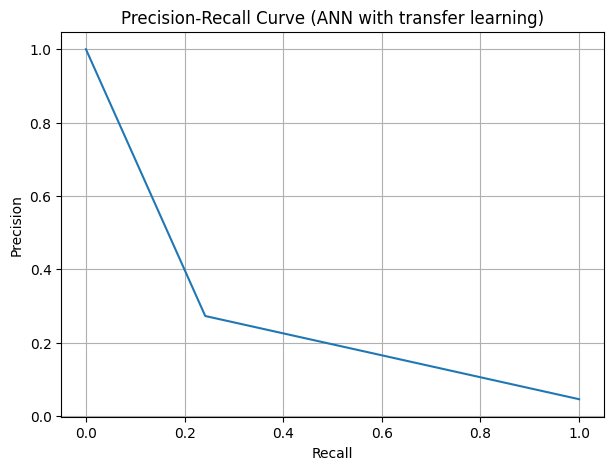

F1 score: 0.2564102564102564


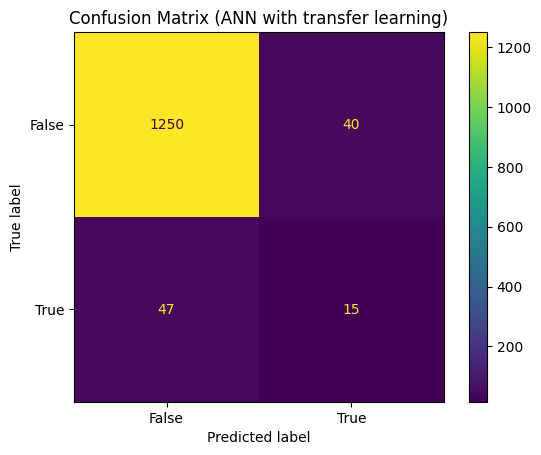

In [67]:
precision_ANN_transfer,recall_ANN_transfer,thresholds_ANN_transfer = precision_recall_curve(y_test,predicted_ANN_transfer)
aucpr_ANN_transfer = auc(recall_ANN_transfer, precision_ANN_transfer)

print(f"AUCPR (trapezoidal) = {aucpr_ANN_transfer:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_ANN_transfer, precision_ANN_transfer)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (ANN with transfer learning)")
plt.grid(True)
plt.show()

f1_ANN_transfer = f1_score(y_test,predicted_ANN_transfer)

print(f"F1 score: {f1_ANN_transfer}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,predicted_ANN_transfer)
plt.title("Confusion Matrix (ANN with transfer learning)")
plt.show()

## 5. Recurrent Neural Network

In [72]:
from tensorflow.keras.layers import LSTM, Dense

X_in = X_train[:,:time,:]
print(X_in.shape)

model = tf.keras.Sequential([
    LSTM(n_neurons, activation='tanh', return_sequences=True, input_shape=(X_in.shape[1],X_in.shape[2])),  # First LSTM layer
    LSTM(n_neurons, activation='tanh', return_sequences=True),  # Second LSTM layer
    LSTM(n_neurons, activation='tanh', return_sequences=True),  # Second LSTM layer
    LSTM(n_neurons, activation='tanh', return_sequences=True),  # Second LSTM layer
    LSTM(n_neurons, activation='tanh'),
    Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(l2=l2reg)),
    Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(l2=l2reg)),
    Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(l2=l2reg)),
    Dense(n_neurons, activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(l2=l2reg)),
    tf.keras.layers.Dropout(rate=0.1),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,alpha=myhps.get('alpha'),gamma=myhps.get('gamma'))
model.compile(loss=loss,optimizer =  tf.keras.optimizers.AdamW(learning_rate=b_lr), metrics=[tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.F1Score(average="macro", threshold=0.5)])
model.summary()

model.fit(X_train[:,:time,:], y_train, epochs=10, batch_size=200)
predicted_RNN = model.predict(X_test[:,:time,:]).flatten().round()


(10810, 50, 16)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 50, 705)        │     2,036,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 50, 705)        │     3,979,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 50, 705)        │     3,979,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 50, 705)        │     3,979,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 705)            │     3,979,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 705)            │       497,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 705)            │       497,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 705)            │       497,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 705)            │       497,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 705)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 1)              │           706 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,943,746 (152.16 MB)

 Trainable params: 19,943,746 (152.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - auc_23: 0.0608 - f1_score: 0.0735 - loss: 0.0311
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc_23: 0.1577 - f1_score: 0.1678 - loss: 0.0256
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc_23: 0.1763 - f1_score: 0.1657 - loss: 0.0251
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc_23: 0.1943 - f1_score: 0.2144 - loss: 0.0247
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc_23: 0.1895 - f1_score: 0.1852 - loss: 0.0240
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc_23: 0.2005 - f1_score: 0.2630 - loss: 0.0239
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc_23: 0.2048 - f1_score: 0.2763 - loss: 0.0233
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc_23: 0.2157 - f1_score: 0.2593 - loss: 0.0233
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc_23: 0.2203 - f1_score: 0.2600 - loss: 0.0230
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - auc_23: 0.2024 - 

AUCPR (trapezoidal) = 0.3091


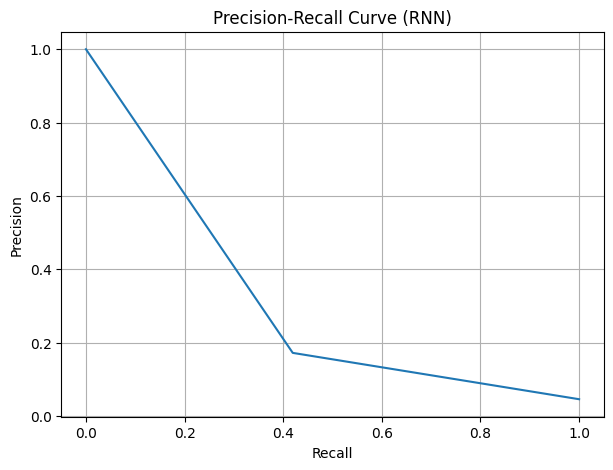

F1 score: 0.24413145539906103


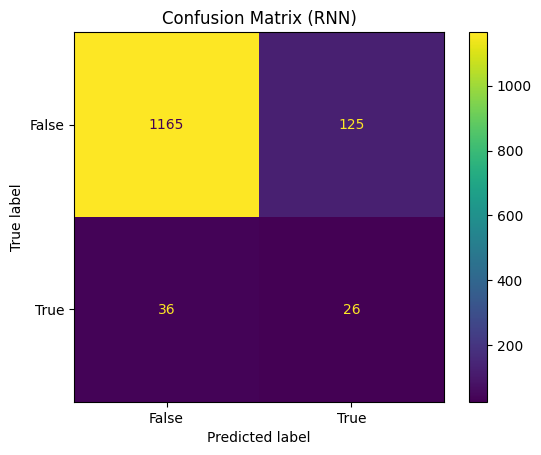

In [73]:
precision_RNN,recall_RNN,thresholds_RNN = precision_recall_curve(y_test,predicted_RNN)
aucpr_RNN = auc(recall_RNN, precision_RNN)

print(f"AUCPR (trapezoidal) = {aucpr_RNN:.4f}")


plt.figure(figsize=(7,5))
plt.plot(recall_RNN, precision_RNN)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (RNN)")
plt.grid(True)
plt.show()

f1_RNN = f1_score(y_test,predicted_RNN)

print(f"F1 score: {f1_RNN}")

disp = ConfusionMatrixDisplay.from_predictions(y_test,predicted_RNN)
plt.title("Confusion Matrix (RNN)")
plt.show()